# Data labeling & Sentiment Analysis

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import openai
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from transformers import AutoModelForSequenceClassification
# OpenAI API
client = openai.OpenAI(api_key="s")

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_entities_senti.parquet", engine="pyarrow")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['year_month'] = df['date'].dt.to_period('M').astype(str)

In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry,named_entities,year_month,vader_sentiment
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750,247,247_instapundit_heather havrilesky_tcs daily_t...,Technology,"{'LOCATION': ['NEW YORK CITY', 'New Y', 'Iraq'...",2022-01,-0.7256
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253,20,20_automotive industry_automotive_automaker_el...,Sport,"{'LOCATION': [], 'ORG': ['Vikatan Originals'],...",2022-01,0.9994
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['US', 'China', 'Xinjiang'], 'ORG...",2022-01,0.9882
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['India', 'US', 'India', 'US', 'U...",2022-01,0.9994
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000,492,492_india magazine_analytic india_datum scient...,Technology,"{'LOCATION': [], 'ORG': [], 'PERSON': [], 'TEC...",2022-01,0.0000


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load Data
sample_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/labeled_news_sentiment.csv")
sample_df = sample_df.dropna(subset=['gpt_sentiment'])
sample_df = sample_df[sample_df['gpt_sentiment'].isin(['positive', 'neutral', 'negative'])].copy()
sample_df['label'] = sample_df['gpt_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [ ]:
dataset = Dataset.from_pandas(sample_df[['clean_text_with_punct', 'label']])

In [ ]:
# Tokenize
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize_truncate(example):
    return tokenizer(example["clean_text_with_punct"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_truncate, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='no',
    eval_strategy='no',
    report_to="none"
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to("cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'f1_micro': f1_score(labels, preds, average='micro')
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
#!pip install --upgrade transformers datasets numpy torch

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sample_df, test_size=0.2, stratify=sample_df['label'], random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [ ]:
trainer.train()

Step,Training Loss
50,0.947900


TrainOutput(global_step=57, training_loss=0.9233242754350629, metrics={'train_runtime': 10.6143, 'train_samples_per_second': 42.396, 'train_steps_per_second': 5.37, 'total_flos': 118401037977600.0, 'train_loss': 0.9233242754350629, 'epoch': 3.0})

In [ ]:
# Prediction Function
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
def predict_sentiment(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
    return label_map[pred_label]

In [ ]:
# Inference on Full Dataset
sample_df['bert_sentiment'] = sample_df['clean_text_with_punct'].apply(lambda x: predict_sentiment(model, tokenizer, x))

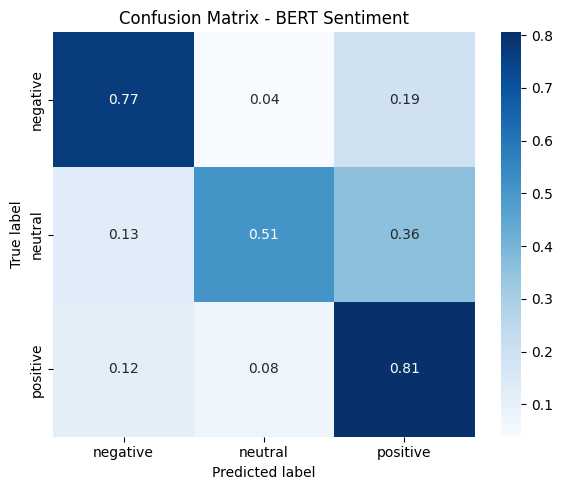

Classification Report:

              precision    recall  f1-score   support

    negative       0.57      0.77      0.66        26
     neutral       0.77      0.51      0.62        47
    positive       0.74      0.81      0.77        77

    accuracy                           0.71       150
   macro avg       0.69      0.70      0.68       150
weighted avg       0.72      0.71      0.70       150



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
inv_label_map = {v: k for k, v in label_map.items()}

# label
y_true = sample_df['label'].map(int).tolist()
y_pred = sample_df['bert_sentiment'].map(label_map).tolist()

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[inv_label_map[i] for i in [0,1,2]],
            yticklabels=[inv_label_map[i] for i in [0,1,2]])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - BERT Sentiment')
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=[inv_label_map[i] for i in [0,1,2]]))

In [ ]:
# Inference on Full Dataset
df['bert_sentiment'] = df['clean_text_with_punct'].apply(lambda x: predict_sentiment(model, tokenizer, x))

In [ ]:
df.to_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_entities_senti_bert.parquet", engine="pyarrow", index=False)

In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry,named_entities,year_month,vader_sentiment,bert_sentiment
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750,247,247_instapundit_heather havrilesky_tcs daily_t...,Technology,"{'LOCATION': ['NEW YORK CITY', 'New Y', 'Iraq'...",2022-01,-0.7256,negative
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253,20,20_automotive industry_automotive_automaker_el...,Sport,"{'LOCATION': [], 'ORG': ['Vikatan Originals'],...",2022-01,0.9994,positive
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['US', 'China', 'Xinjiang'], 'ORG...",2022-01,0.9882,neutral
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['India', 'US', 'India', 'US', 'U...",2022-01,0.9994,neutral
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000,492,492_india magazine_analytic india_datum scient...,Technology,"{'LOCATION': [], 'ORG': [], 'PERSON': [], 'TEC...",2022-01,0.0000,positive


<ipython-input-25-baad194c2bb9>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  timeline = df.groupby([pd.Grouper(key='date', freq='M'), 'Predicted_Industry'])['bert_sentiment'].value_counts().unstack().fillna(0)


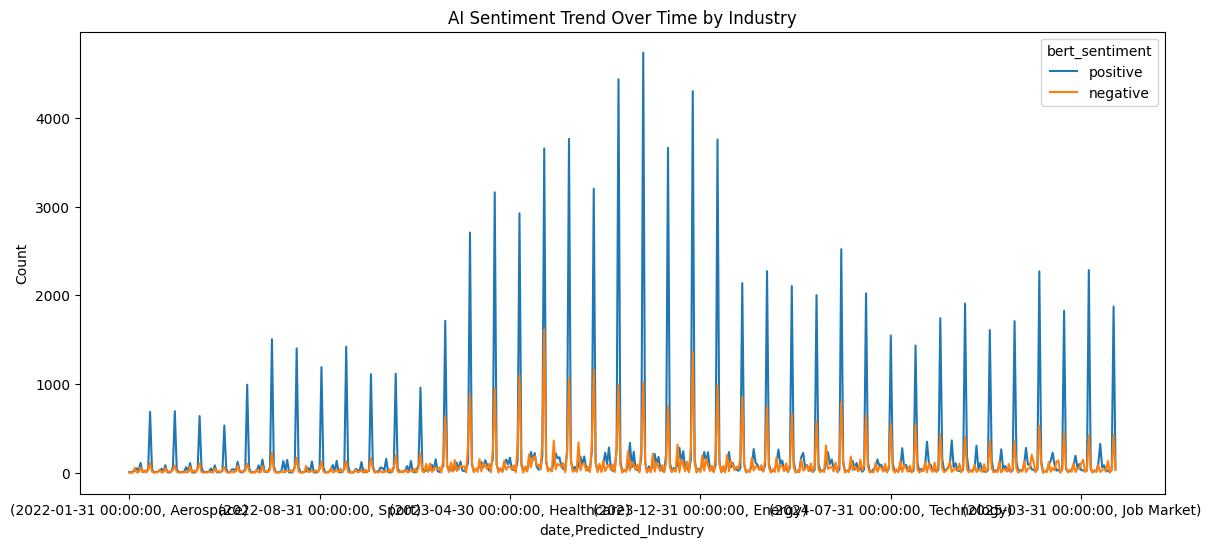

In [ ]:
# Sentiment Timeline Visualization
df['date'] = pd.to_datetime(df['date'])
timeline = df.groupby([pd.Grouper(key='date', freq='M'), 'Predicted_Industry'])['bert_sentiment'].value_counts().unstack().fillna(0)
timeline[['positive', 'negative']].plot(kind='line', figsize=(14, 6))
plt.title('AI Sentiment Trend Over Time by Industry')
plt.ylabel('Count')
plt.show()

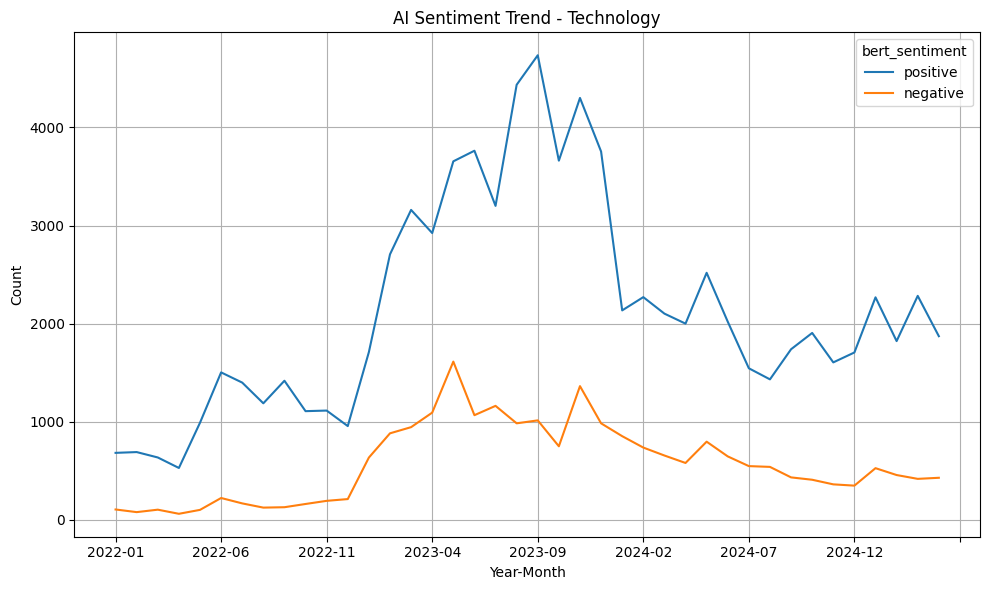

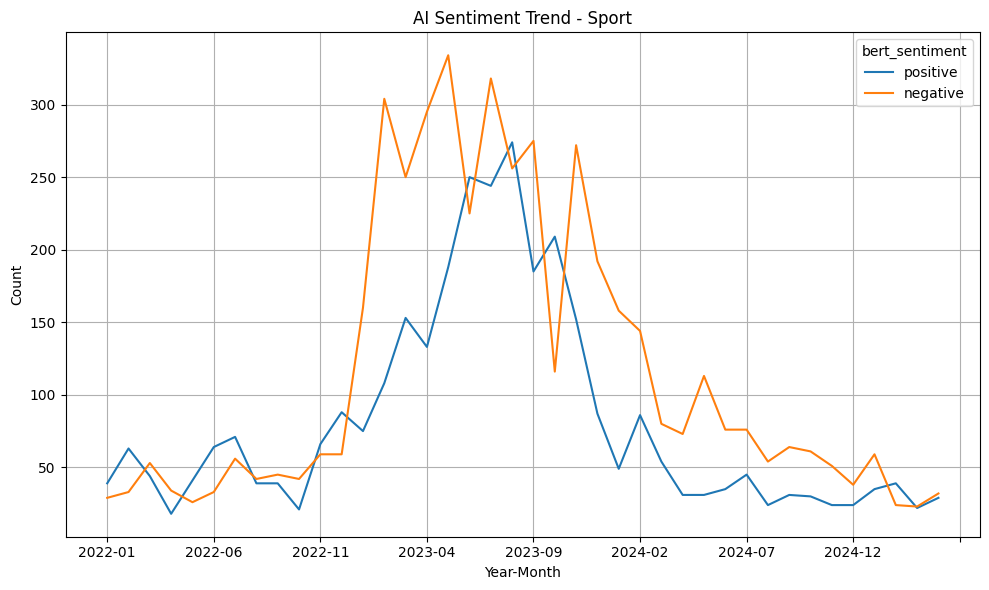

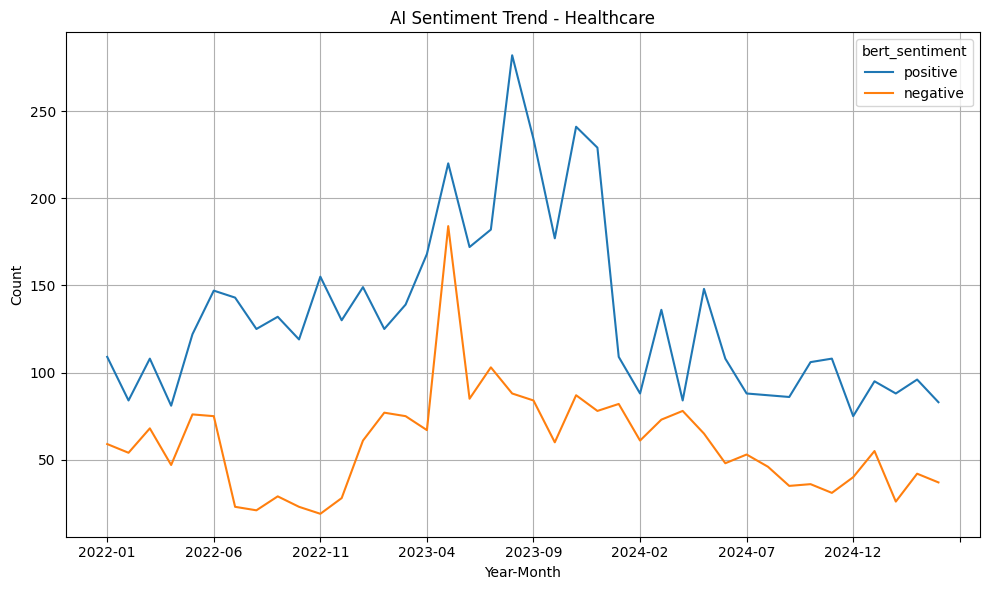

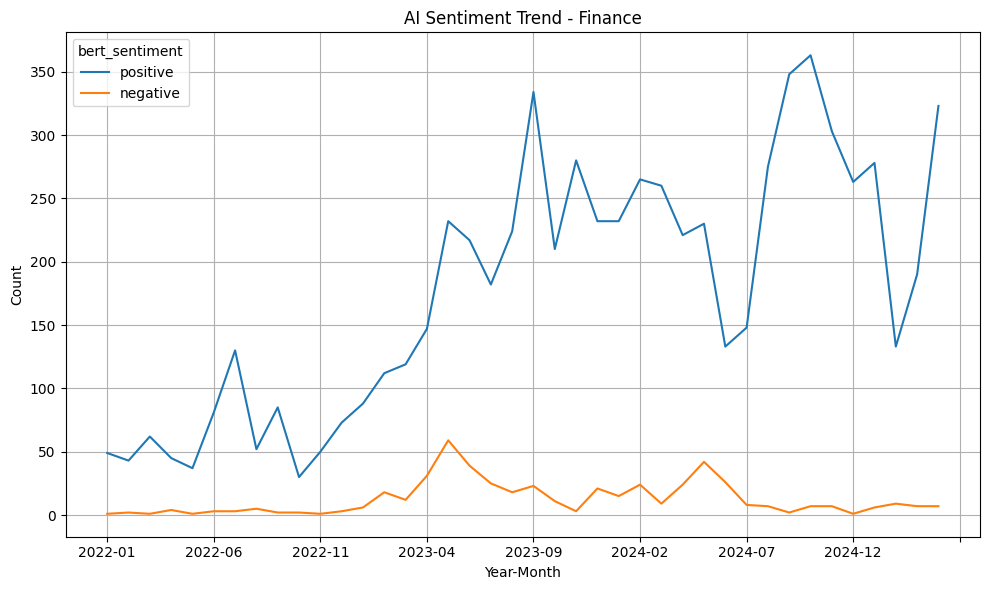

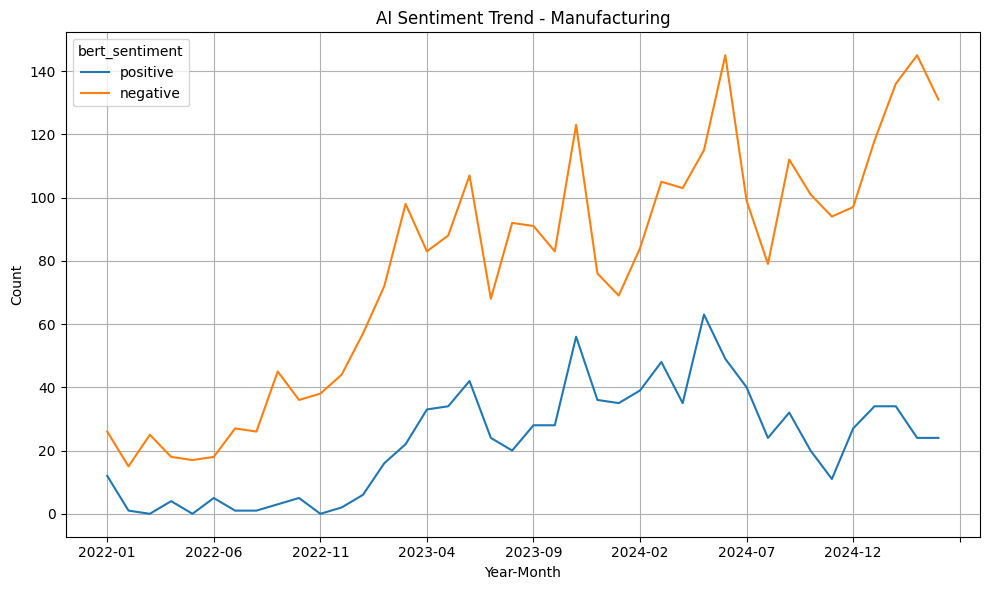

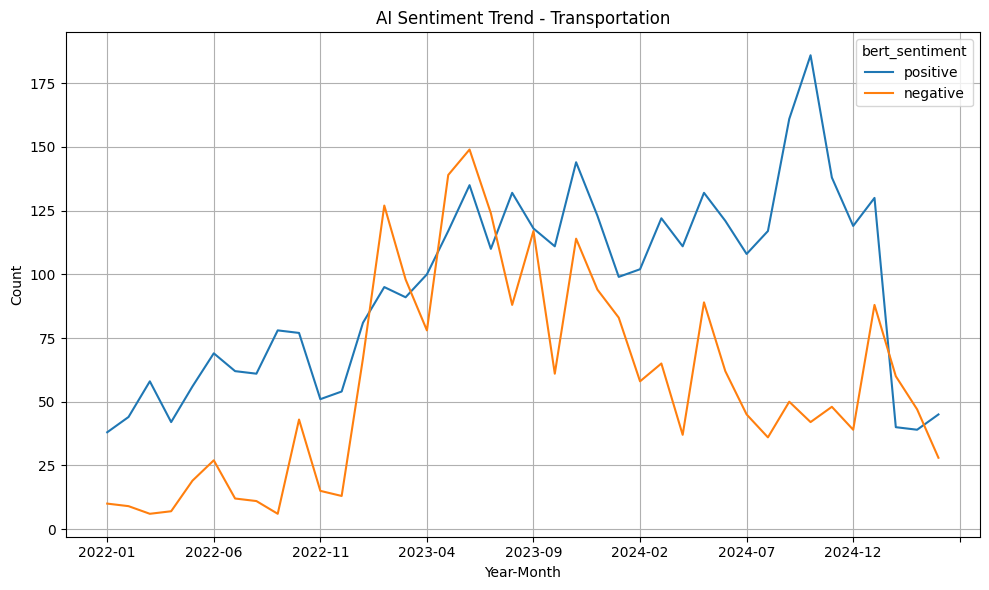

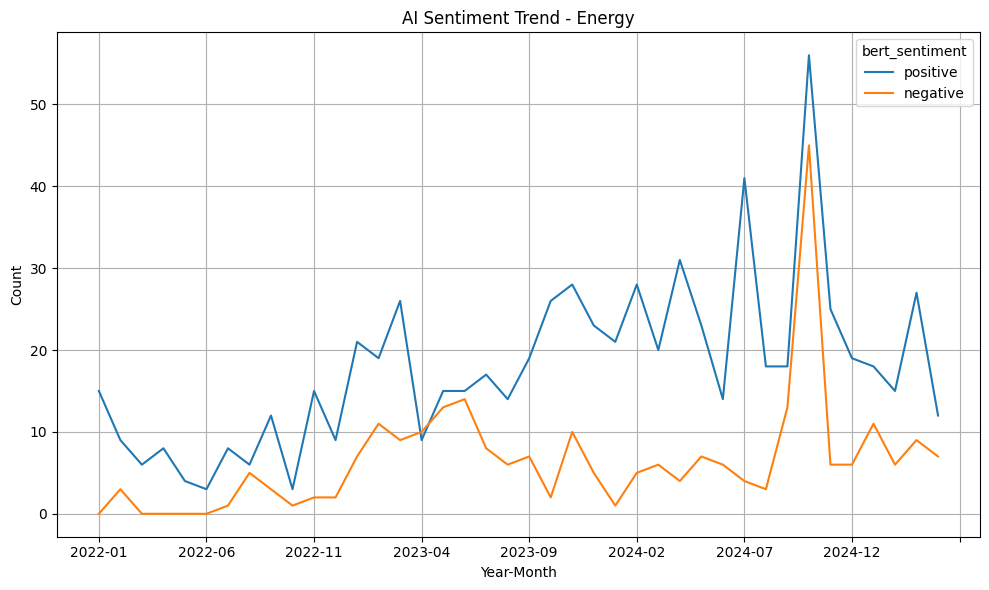

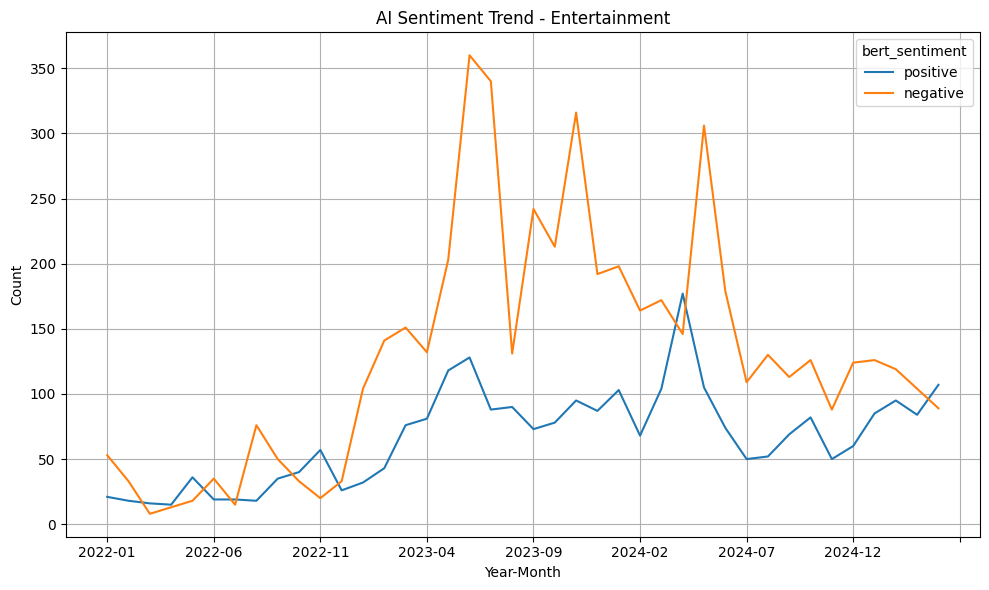

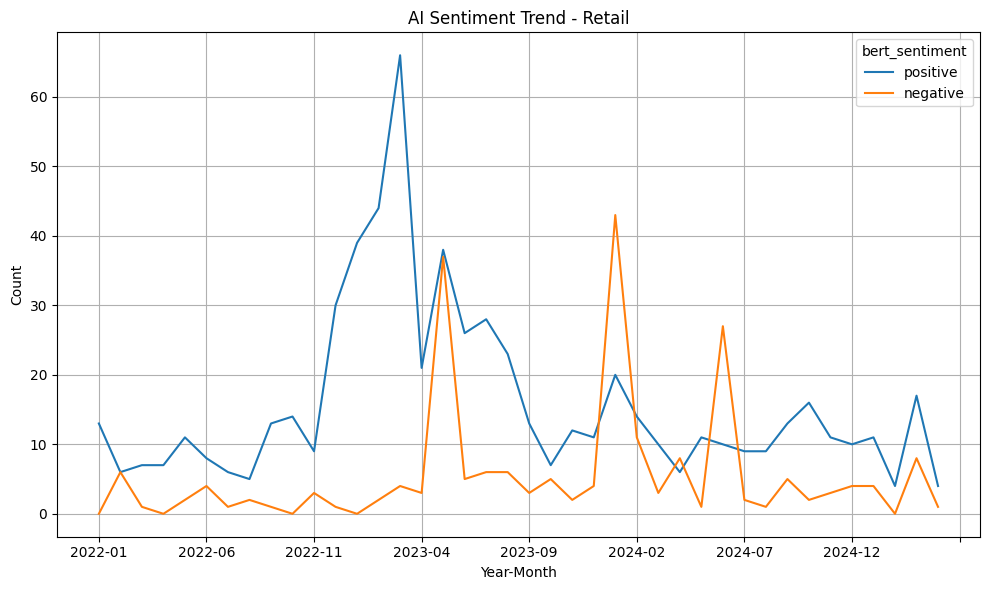

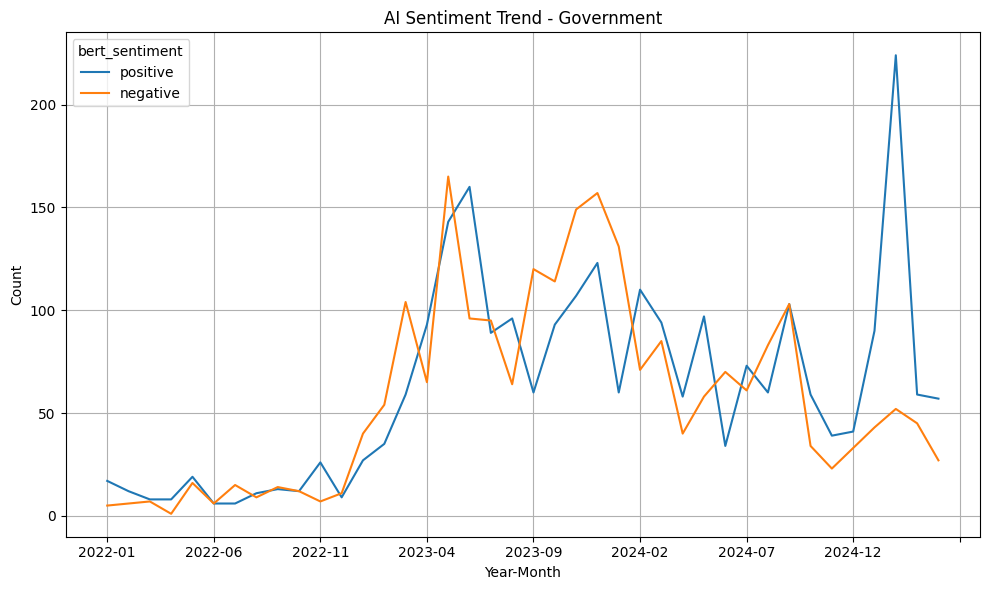

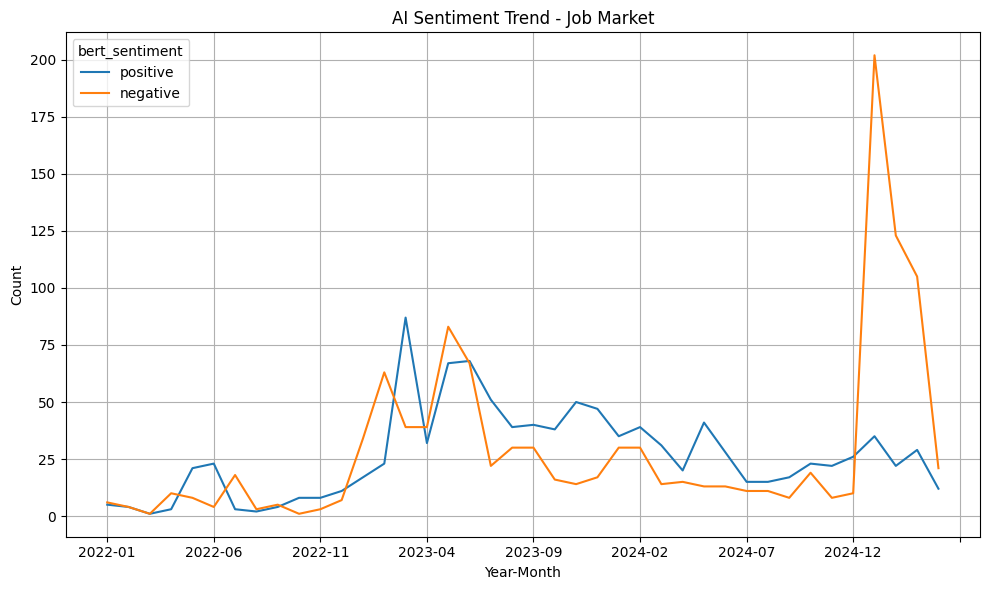

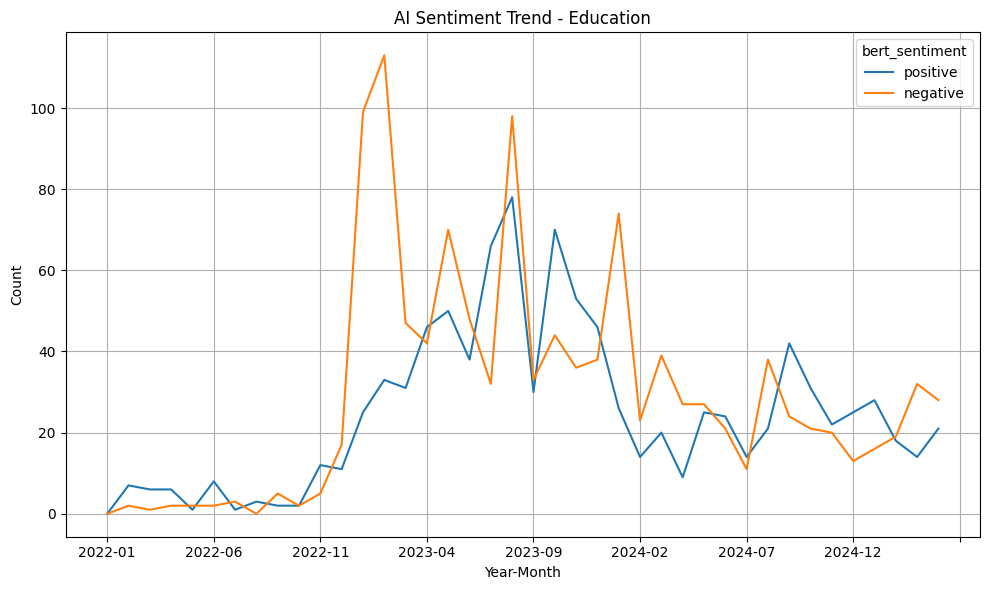

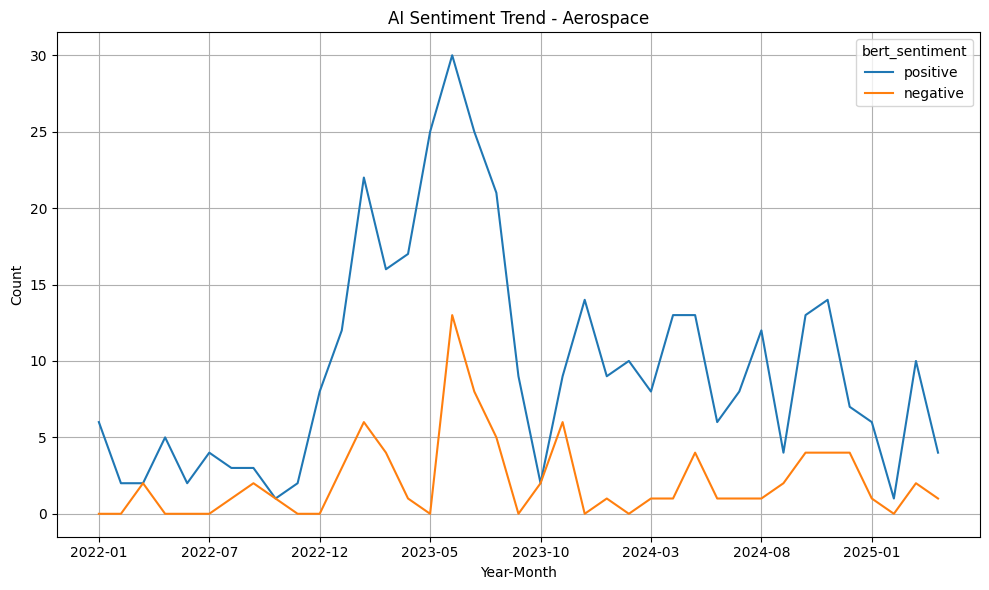

In [ ]:
df['date'] = pd.to_datetime(df['date'])

df['year_month'] = df['date'].dt.to_period('M').astype(str)

timeline = df.groupby(['year_month', 'Predicted_Industry'])['bert_sentiment'].value_counts().unstack().fillna(0)

timeline = timeline.reset_index().sort_values('year_month')

industries = df['Predicted_Industry'].unique()
for industry in industries:
    subset = timeline[timeline['Predicted_Industry'] == industry]
    subset.plot(x='year_month', y=['positive', 'negative'], kind='line', figsize=(10, 6), title=f'AI Sentiment Trend - {industry}')
    plt.xticks(rotation=360)
    plt.ylabel('Count')
    plt.xlabel('Year-Month')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Group sentiment by industry
industry_sentiment = df.groupby('Predicted_Industry')['bert_sentiment'].value_counts(normalize=True).unstack().fillna(0)
industry_sentiment['net_positive'] = industry_sentiment['positive'] - industry_sentiment['negative']
industry_sentiment.sort_values('net_positive', ascending=False).head(10)  # Most positively affected
industry_sentiment.sort_values('net_positive')#.head(10)  # Most negatively affected

bert_sentiment,negative,neutral,positive,net_positive
Predicted_Industry,,,,
Manufacturing,0.693304,0.101786,0.204911,-0.488393
Entertainment,0.587008,0.111424,0.301568,-0.285440
Sport,0.542496,0.078202,0.379302,-0.163194
Education,0.491831,0.098031,0.410138,-0.081693
Job Market,0.322824,0.380859,0.296317,-0.026507
Government,0.350896,0.267729,0.381375,0.030479
Transportation,0.370947,0.016372,0.612681,0.241734
Healthcare,0.255093,0.170384,0.574523,0.319430
Energy,0.199536,0.246713,0.553751,0.354215


In [ ]:
# Filter companies with positive sentiment and future-related terms
df[df['bert_sentiment'] == 'positive']['named_entities'].apply(lambda x: x['ORG']).explode().value_counts().head(20)

,count
named_entities,
Google,103833
Microsoft,79496
OpenAI,76487
Apple,57236
LG,44164
Nvidia,32436
Amazon,30020
Samsung,29354
ChatGPT,26031


In [ ]:
failures = df[df['clean_text_with_punct'].str.contains("AI cannot|AI fails|AI limitation|not ready", case=False, na=False)]
failures[['date', 'title', 'Predicted_Industry', 'clean_text_with_punct']].head(5)

,date,title,Predicted_Industry,clean_text_with_punct
259,2022-01-06,Does AI Qualify As An ‘Inventor' Based The Sta...,Healthcare,Does AI Qualify As An Inventor' Based The Stat...
658,2022-01-16,The Apprentice's Karren Brady gives Claude Lit...,Entertainment,The Apprentice's Karren Brady gives Claude Lit...
943,2022-01-21,"Explainer | Artificial Intelligence, And Its I...",Technology,"Explainer | Artificial Intelligence, And Its I..."
1184,2022-01-25,Artificial intelligence,Technology,Artificial intelligence SlideShare uses to imp...
1829,2022-02-07,Why artificial intelligence will never replace...,Technology,Why artificial intelligence will never replace...


In [ ]:
# Sample supporting texts
positive_samples = df[df['bert_sentiment'] == 'positive'].sample(5)
negative_samples = df[df['bert_sentiment'] == 'negative'].sample(5)

In [ ]:
negative_samples

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry,named_entities,year_month,vader_sentiment,bert_sentiment
1366,1366,https://www.latestly.com/agency-news/india-new...,2022-01-27,en,India News | Nation's Eyes on Us: Tata Sons Ch...,\n\nIndia News | Nation's Eyes on Us: Tata Son...,India | Nation's Eyes on Us: Tata Sons Chairma...,india nation eye tata son chairman employee t...,14,0.830405,14,14_india politics_entertainment bollywood_boll...,Entertainment,"{'LOCATION': ['India', 'India', 'Sri Lanka', '...",2022-01,0.9992,negative
144411,144411,https://www.ypradio.org/2024-07-10/artificial-...,2024-07-10,en,Artificial intelligence's thirst for electrici...,\nArtificial intelligence's thirst for electri...,Artificial intelligence's thirst for electrici...,thirst electricity ypr search query search re...,520,1.000000,520,520_fm donation_fm underwriters_form fm_donati...,Technology,"{'LOCATION': ['The Big Sky', 'The Big Sky', 'S...",2024-07,0.9595,negative
114016,114016,https://mobilesyrup.com/2024/01/11/rabbit-r1-s...,2024-01-11,en,"Rabbit sold 10,000 R1 AI devices in 24 hours","\nRabbit sold 10,000 R1 AI devices in 24 hours...","Rabbit sold 10,000 R1 AI devices in 24 hours C...",rabbit sell device hour contact syrupcast con...,190,1.000000,190,190_gaming app_accessory gaming_edt new_playst...,Entertainment,"{'LOCATION': ['Montreal', 'Montreal', 'B.C.', ...",2024-01,0.9998,negative
105433,105433,https://www.lg.com/ca_en/backups/tvs-soundbars...,2023-12-04,en,"70"" UN73 LG UHD TV with ThinQ® AI - 70UN7370AU...","\n\n\n70"" UN73 LG UHD TV with ThinQ® AI - 70UN...","70"" UN73 LG UHD TV with ThinQ AI - 70UN7370AUD...",lg uhd tv thinq lg javascript appear disable ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['Canada', 'Canada', 'Canada'], '...",2023-12,0.9999,negative
68190,68190,https://www.wemu.org/2023-07-19/how-ai-could-p...,2023-07-19,en,"How AI could perpetuate racism, sexism and oth...","\n\nHow AI could perpetuate racism, sexism and...","How AI could perpetuate racism, sexism and oth...",perpetuate racism sexism bias society wemu fm...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['Ypsi Washtenaw', 'Ypsi Washtena...",2023-07,0.9922,negative


<ipython-input-44-18c263773012>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_mentions['year_month'] = pd.to_datetime(tech_mentions['date']).dt.to_period('M')


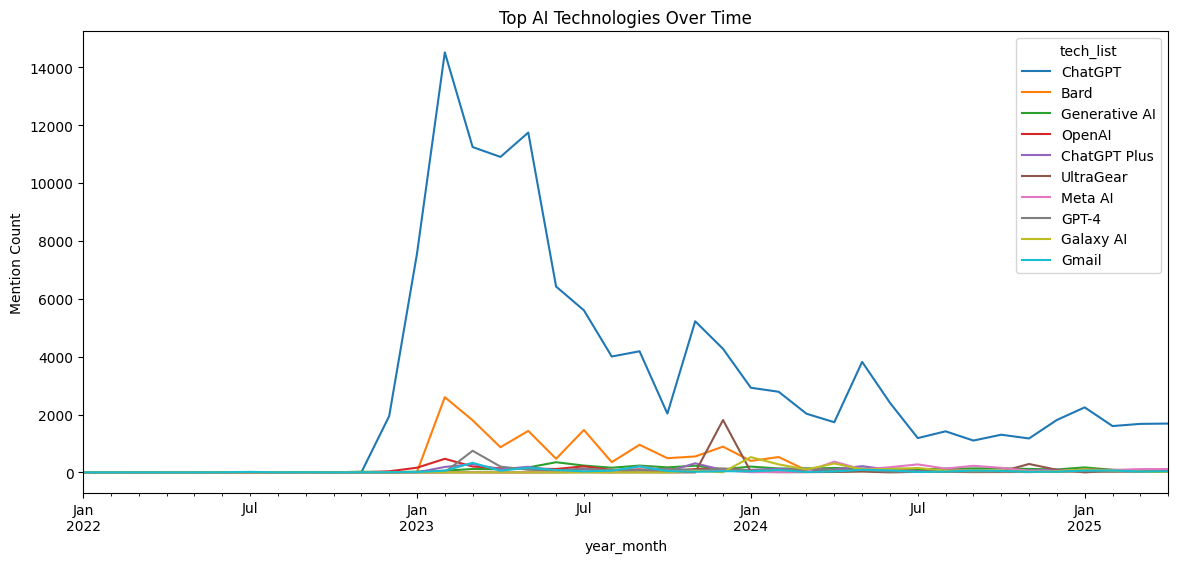

In [ ]:
df['tech_list'] = df['named_entities'].apply(lambda x: x.get('TECH', []) if isinstance(x, dict) else [])

tech_mentions = df.explode('tech_list')
tech_mentions = tech_mentions[tech_mentions['tech_list'].notna() & (tech_mentions['tech_list'] != '')]

tech_mentions['year_month'] = pd.to_datetime(tech_mentions['date']).dt.to_period('M')

tech_counts = tech_mentions.groupby(['year_month', 'tech_list']).size().unstack(fill_value=0)

top_techs = tech_counts.sum().sort_values(ascending=False).head(10).index
tech_counts[top_techs].plot(figsize=(14,6), title="Top AI Technologies Over Time")
plt.ylabel("Mention Count")
plt.show()

Another try

In [ ]:
import numpy
import transformers
import datasets
import torch

print("numpy version:", numpy.__version__)
print("datasets version:", datasets.__version__)
print("transformers version:", transformers.__version__)
print("torch version:", torch.__version__)

numpy version: 2.2.6
datasets version: 3.6.0
transformers version: 4.51.3
torch version: 2.6.0+cu124


In [ ]:
print("numpy version:", np.__version__)
print("numpy version:", Dataset.__version__)

numpy version: 2.2.6


AttributeError: type object 'Dataset' has no attribute '__version__'

In [ ]:
# 3. Load Data
sample_df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/labeled_500_sentiment.csv")
sample_df1 = sample_df1.dropna(subset=['gpt_sentiment'])
sample_df1 = sample_df1[sample_df1['gpt_sentiment'].isin(['positive', 'neutral', 'negative'])].copy()
sample_df1['label'] = sample_df1['gpt_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [ ]:
# 選取需要的欄位並建立 Dataset
dataset1 = Dataset.from_pandas(sample_df1[['clean_text_with_punct', 'label']])

In [ ]:
def tokenize_truncate(example):
    return tokenizer(example["clean_text_with_punct"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset1 = dataset1.map(tokenize_truncate, batched=True)
tokenized_dataset1.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset1,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
50,0.547700
100,0.411800
150,0.319900


TrainOutput(global_step=189, training_loss=0.36528482891264413, metrics={'train_runtime': 31.1647, 'train_samples_per_second': 47.939, 'train_steps_per_second': 6.065, 'total_flos': 393091446085632.0, 'train_loss': 0.36528482891264413, 'epoch': 3.0})

In [ ]:
sample_df1['bert_sentiment'] = sample_df1['clean_text_with_punct'].apply(lambda x: predict_sentiment(model, tokenizer, x))

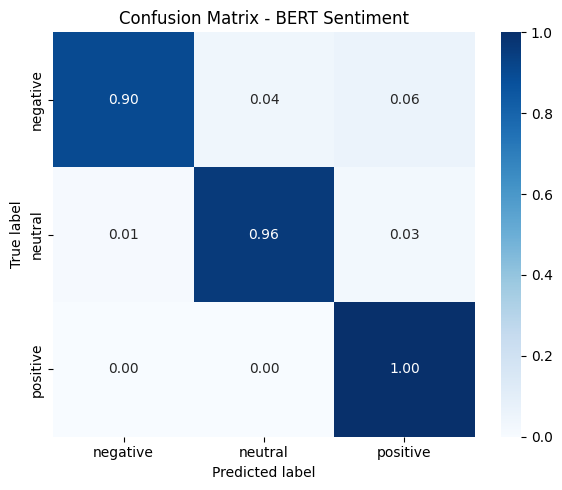

Classification Report:

              precision    recall  f1-score   support

    negative       0.98      0.90      0.94        51
     neutral       0.97      0.96      0.97        74
    positive       0.99      1.00      0.99       373

    accuracy                           0.98       498
   macro avg       0.98      0.95      0.97       498
weighted avg       0.98      0.98      0.98       498



In [ ]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
inv_label_map = {v: k for k, v in label_map.items()}

y_true = sample_df1['label'].map(int).tolist()
y_pred = sample_df1['bert_sentiment'].map(label_map).tolist()

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[inv_label_map[i] for i in [0,1,2]],
            yticklabels=[inv_label_map[i] for i in [0,1,2]])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - BERT Sentiment')
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=[inv_label_map[i] for i in [0,1,2]]))

In [ ]:
df['bert_sentiment_v2'] = df['clean_text_with_punct'].apply(lambda x: predict_sentiment(model, tokenizer, x))

In [ ]:
df.to_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_entities_senti_bert_v2.parquet", engine="pyarrow", index=False)

In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry,named_entities,year_month,vader_sentiment,bert_sentiment,tech_list,bert_sentiment_v2
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750,247,247_instapundit_heather havrilesky_tcs daily_t...,Technology,"{'LOCATION': ['NEW YORK CITY', 'New Y', 'Iraq'...",2022-01,-0.7256,negative,[],positive
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253,20,20_automotive industry_automotive_automaker_el...,Sport,"{'LOCATION': [], 'ORG': ['Vikatan Originals'],...",2022-01,0.9994,positive,[],positive
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['US', 'China', 'Xinjiang'], 'ORG...",2022-01,0.9882,neutral,[],positive
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['India', 'US', 'India', 'US', 'U...",2022-01,0.9994,neutral,[],positive
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000,492,492_india magazine_analytic india_datum scient...,Technology,"{'LOCATION': [], 'ORG': [], 'PERSON': [], 'TEC...",2022-01,0.0000,positive,[],neutral


In [ ]:
# Group sentiment by industry
industry_sentiment = df.groupby('Predicted_Industry')['bert_sentiment_v2'].value_counts(normalize=True).unstack().fillna(0)
industry_sentiment['net_positive'] = industry_sentiment['positive'] - industry_sentiment['negative']
industry_sentiment.sort_values('net_positive', ascending=False).head(10)  # Most positively affected
industry_sentiment.sort_values('net_positive')#.head(10)  # Most negatively affected

bert_sentiment_v2,negative,neutral,positive,net_positive
Predicted_Industry,,,,
Entertainment,0.201985,0.080411,0.717605,0.515620
Government,0.158677,0.075969,0.765355,0.606678
Sport,0.139195,0.104191,0.756614,0.617420
Education,0.116883,0.044826,0.838291,0.721408
Job Market,0.060826,0.133650,0.805525,0.744699
Technology,0.070121,0.113080,0.816799,0.746678
Transportation,0.079936,0.018620,0.901445,0.821509
Finance,0.014925,0.139188,0.845887,0.830961
Healthcare,0.044714,0.068304,0.886983,0.842269


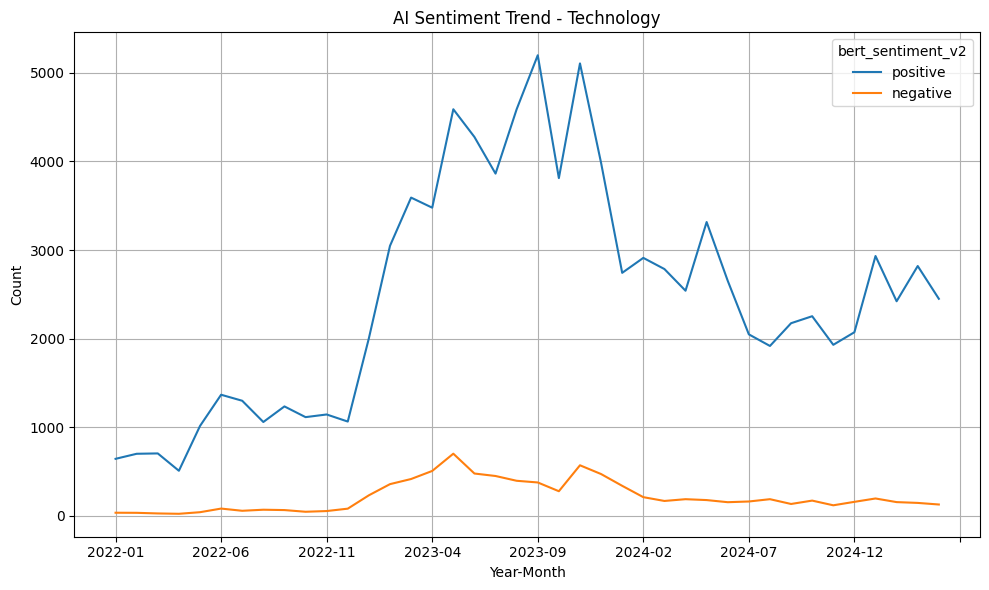

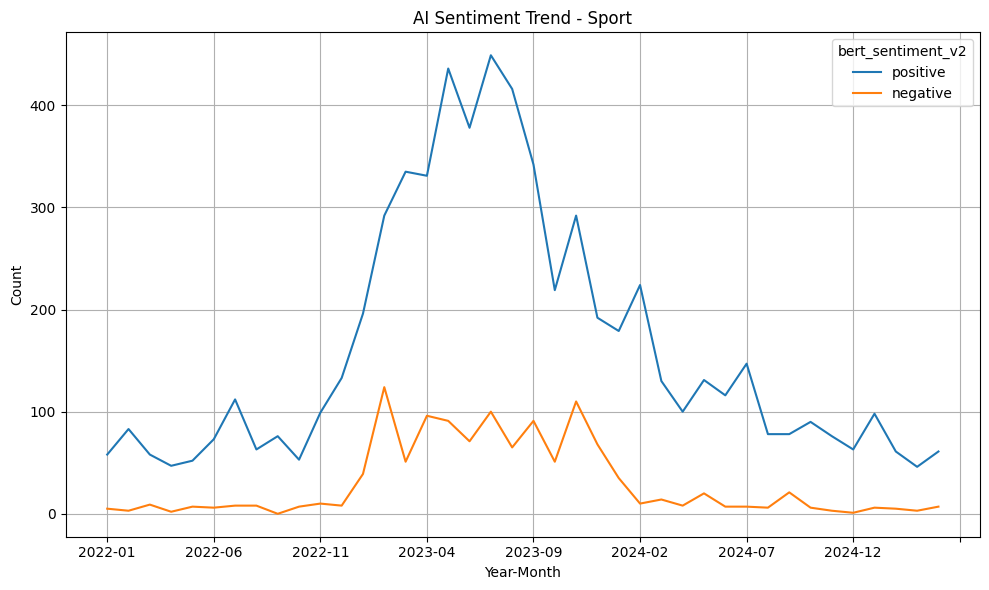

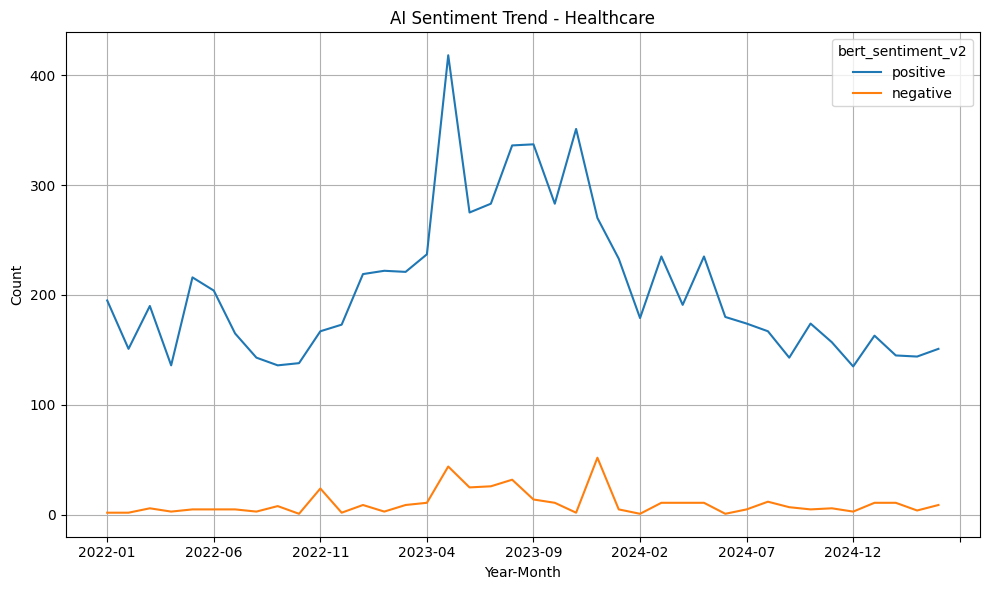

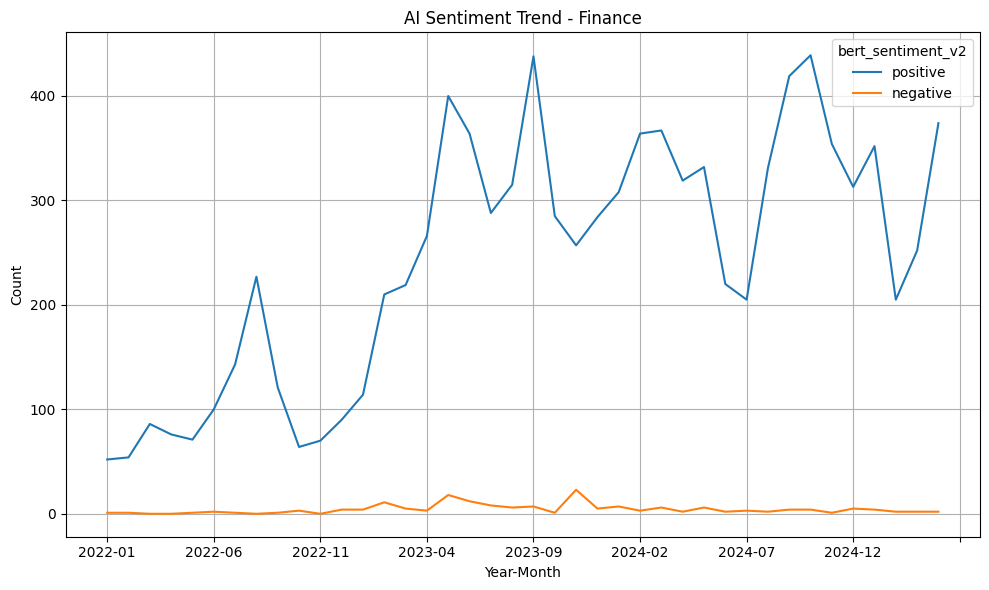

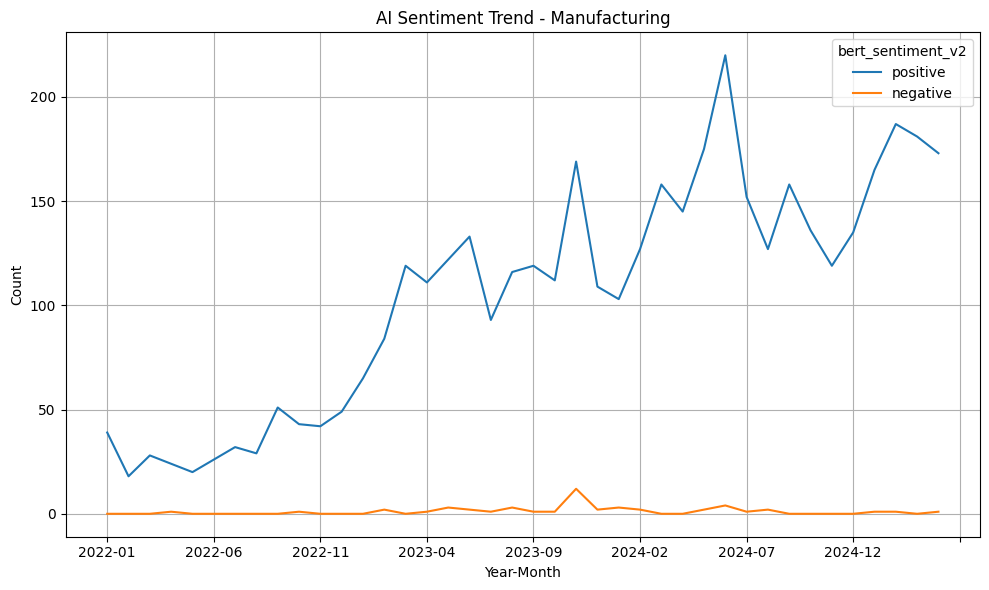

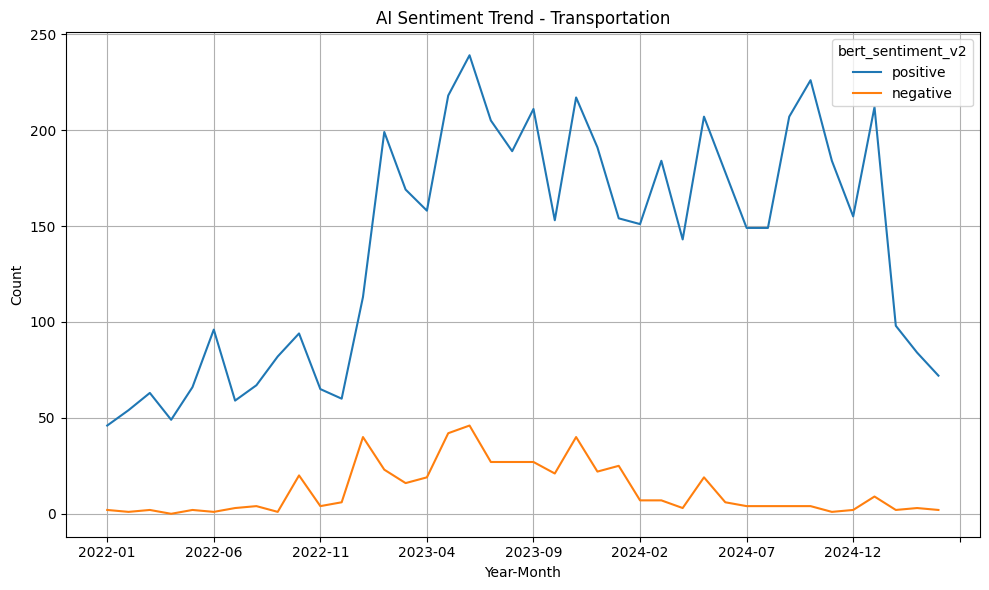

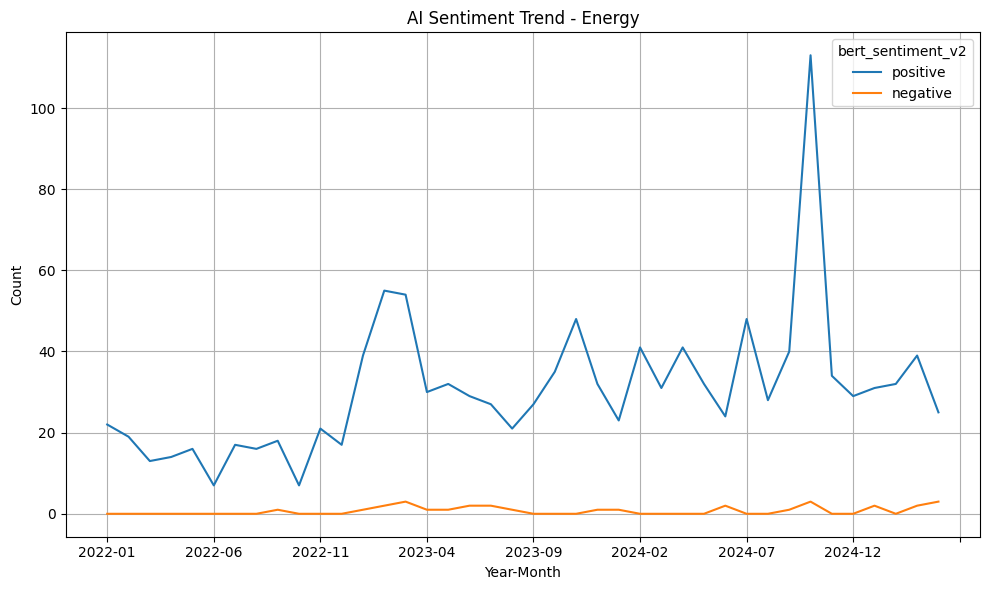

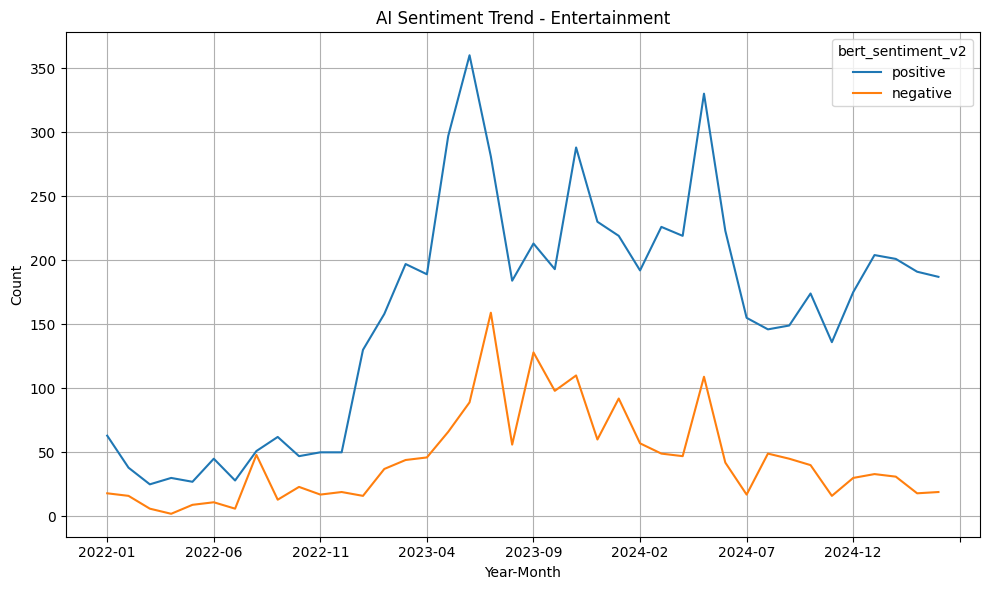

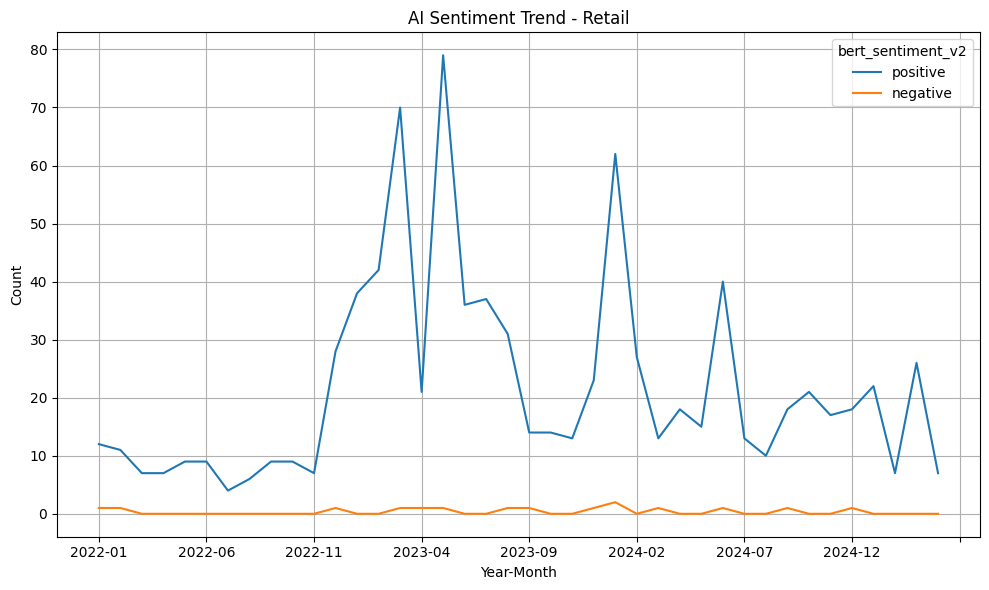

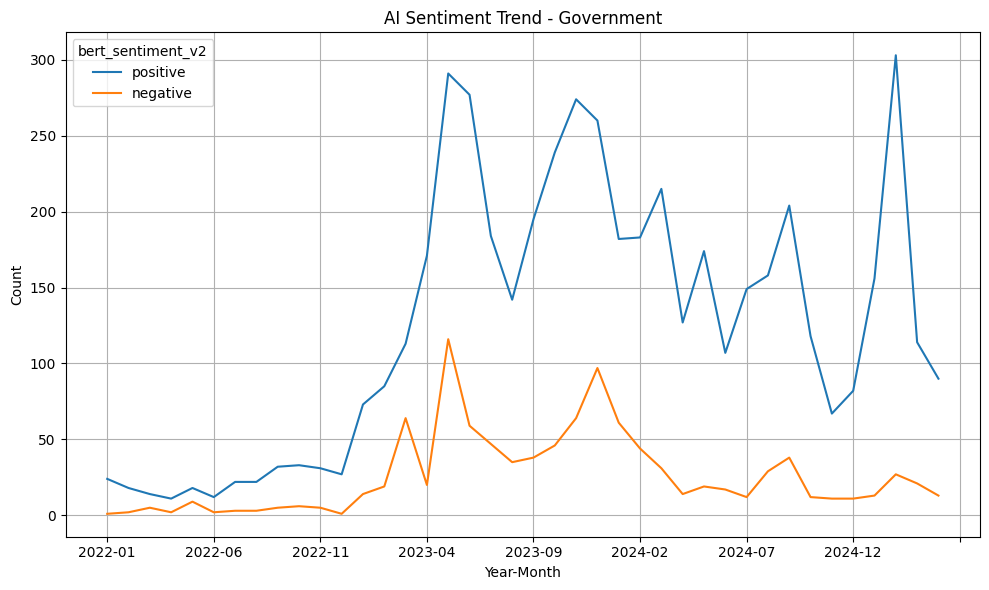

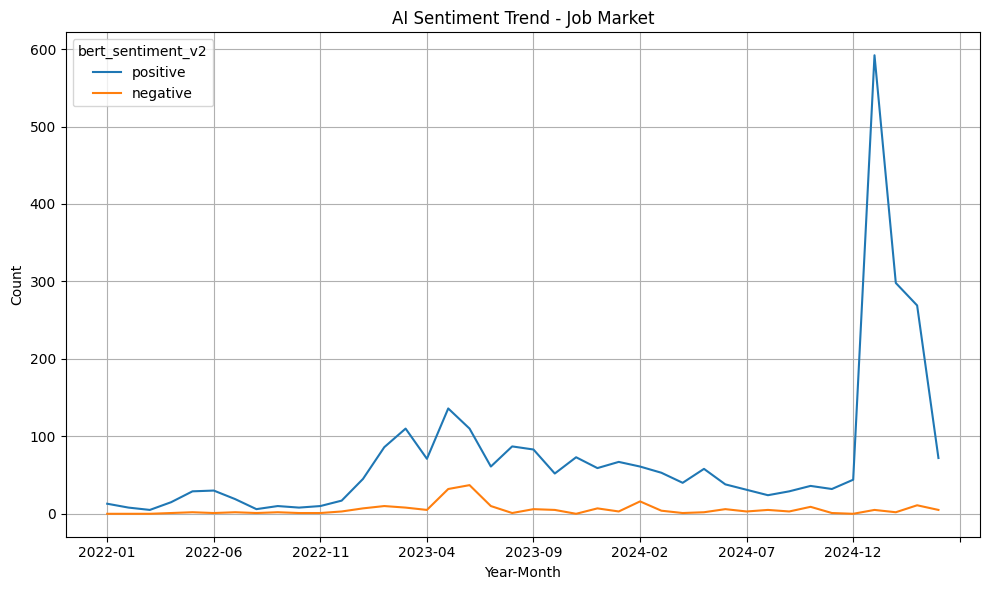

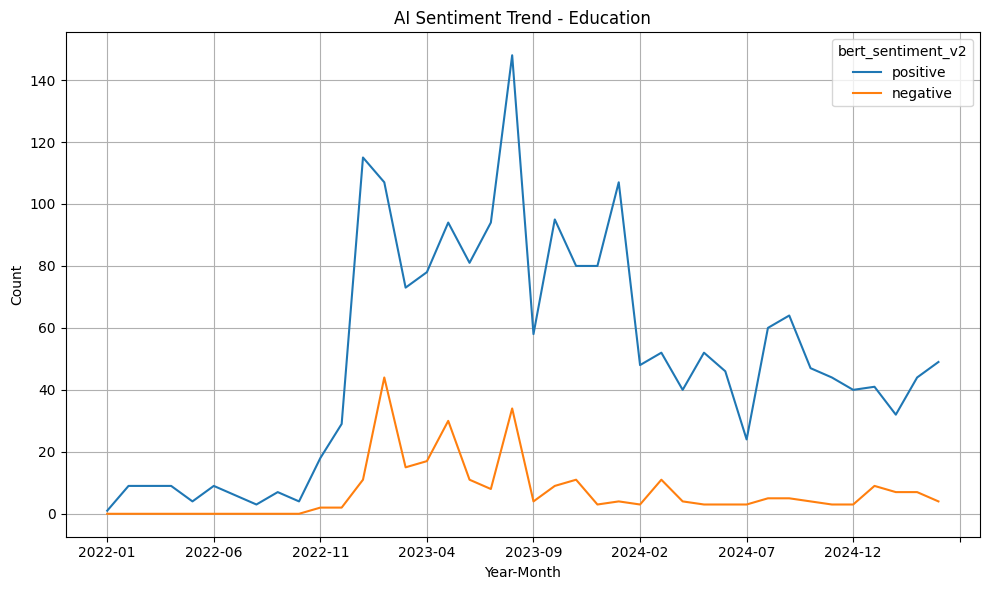

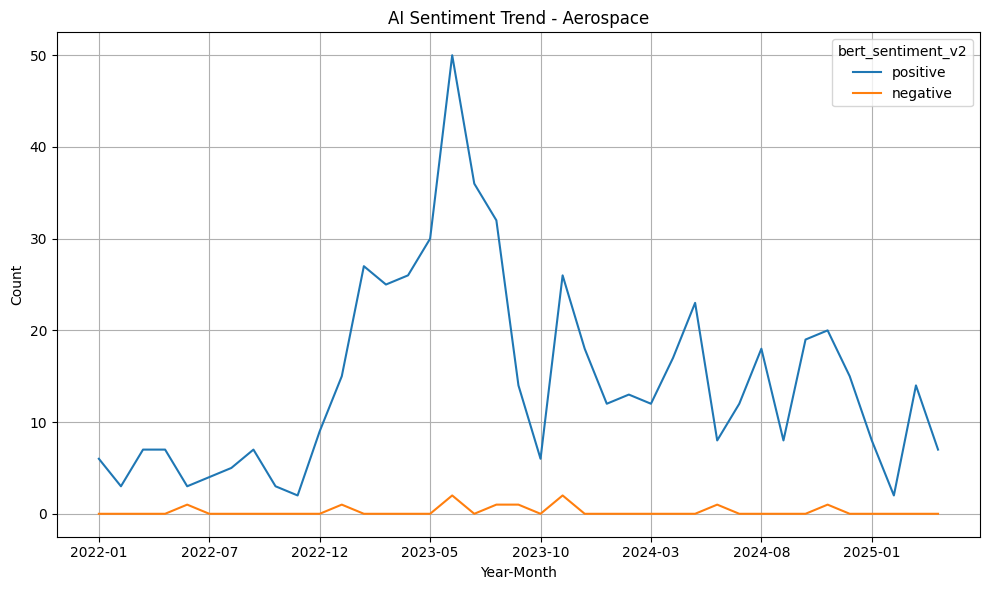

In [ ]:
df['date'] = pd.to_datetime(df['date'])

df['year_month'] = df['date'].dt.to_period('M').astype(str)

timeline = df.groupby(['year_month', 'Predicted_Industry'])['bert_sentiment_v2'].value_counts().unstack().fillna(0)

timeline = timeline.reset_index().sort_values('year_month')

industries = df['Predicted_Industry'].unique()
for industry in industries:
    subset = timeline[timeline['Predicted_Industry'] == industry]
    subset.plot(x='year_month', y=['positive', 'negative'], kind='line', figsize=(10, 6), title=f'AI Sentiment Trend - {industry}')
    plt.xticks(rotation=360)
    plt.ylabel('Count')
    plt.xlabel('Year-Month')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
df1 = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_entities_senti_bert_v2.parquet", engine="pyarrow")
df1.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry,named_entities,year_month,vader_sentiment,bert_sentiment,tech_list,bert_sentiment_v2
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750,247,247_instapundit_heather havrilesky_tcs daily_t...,Technology,"{'LOCATION': ['NEW YORK CITY', 'New Y', 'Iraq'...",2022-01,-0.7256,negative,[],positive
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253,20,20_automotive industry_automotive_automaker_el...,Sport,"{'LOCATION': [], 'ORG': ['Vikatan Originals'],...",2022-01,0.9994,positive,[],positive
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['US', 'China', 'Xinjiang'], 'ORG...",2022-01,0.9882,neutral,[],positive
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'LOCATION': ['India', 'US', 'India', 'US', 'U...",2022-01,0.9994,neutral,[],positive
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000,492,492_india magazine_analytic india_datum scient...,Technology,"{'LOCATION': [], 'ORG': [], 'PERSON': [], 'TEC...",2022-01,0.0000,positive,[],neutral
